<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb&fileName=gefcom14-s-nnqf"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Download data

In [ ]:
!echo "Downloading GEFCom14-S..."
!rm -R data > /dev/null
!wget -O gefcom14.zip https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
!unzip gefcom14 > /dev/null
!rm gefcom14.zip > /dev/null
!unzip GEFCom2014\ Data/GEFCom2014-S_V2.zip > /dev/null
!rm -R GEFCom2014\ Data > /dev/null
!mv Solar data > /dev/null
!echo "------------------------------"
!echo "Downloaded GEFCom14-S in data/"

# Select Task

In [2]:
task = 9

# Prepare data

In [3]:
import numpy as np
import pandas as pd

# only use surface solar radiation (169), surface thermal radiation (175) and top net solar radiation (178)
predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR169', 'VAR175', 'VAR178']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task + 1}/train{task + 1}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task}/benchmark{'0' + str(task) if task < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)

predictors_categories = [predictors[predictors['ZONEID'] == i][['VAR169', 'VAR175', 'VAR178']]
                             .rename({'VAR169': f'SURFACE SOLAR RADIATION {i}',
                                      'VAR175': f'SURFACE THERMAL RADIATION {i}',
                                      'VAR178': f'TOP NET SOLAR RADIATION {i}'}, axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)

In [4]:
gefcom14_metadata = {
    'num_series': 3,
    'num_steps': len(predictor_data),
    'prediction_length': len(benchmark) // 3,
    'start': predictor_data.index[0]
}

In [5]:
for i in range(1, 4):
    predictor_data[f'SURFACE SOLAR RADIATION {i}'] /= predictor_data[f'SURFACE SOLAR RADIATION {i}'].max()
    predictor_data[f'SURFACE THERMAL RADIATION {i}'] /= predictor_data[f'SURFACE THERMAL RADIATION {i}'].max()
    predictor_data[f'TOP NET SOLAR RADIATION {i}'] /= predictor_data[f'TOP NET SOLAR RADIATION {i}'].max()

In [6]:
predictor_zones = []
train_data_zones = []

for zoneid in range(1, 4):
    predictor = predictor_data[[f'SURFACE SOLAR RADIATION {zoneid}', f'SURFACE THERMAL RADIATION {zoneid}', f'TOP NET SOLAR RADIATION {zoneid}']]
    predictor_zones.append(predictor)
    train_data_zone = train_data[[f'ZONEID {zoneid}']]
    train_data_zones.append(train_data_zone)

In [7]:
x_input_zones = []
y_output_zones = []

for predictor, train_data in zip(predictor_zones, train_data_zones):
    x_input_df = predictor[:-gefcom14_metadata['prediction_length']]
    x_input = np.array(x_input_df)
    x_input_zones.append(x_input)
    y_output = np.array(train_data[:-gefcom14_metadata['prediction_length']])
    y_output_zones.append(y_output)

# NNQF

In [8]:
import numpy as np
from sklearn.neighbors import NearestNeighbors as nn_fun

def nnqf_filter(x_input, 
                y_output, 
                num_neighbors = 10, 
                q_quantile = 0.5, 
                var_weighting = True, 
                minkowski_dist = 2):
    """
    Parameters
    ----------
    x_input : numpy array ;
    Input matrix of dimension (N,S), with N representing the number of
    samples and S the number of features

    y_output : numpy array ;
    Output vector of dimension (N,)

    num_neighbors : int, default = 10 ;
    Number of nearest neighbors that the filter is going to search for     

    q_quantile : float, default = 0.5 ;
    Must be a value between 0 and 1. 
    Probability of the quantile that is going to be calculated from the 
    nearest neighbors output values      

    var_weighting : bool, default = True ;
    Value defining if the columns of the input matrix are going to be multiplied 
    by the inverse of their variance

    minkowski_dist : int, default = 2 ;
    Parameter used to define the type of minkoswki distance used to calculate 
    the nearest neighbors

    Returns
    -------
    yq_output : numpy array ;
    New output vector containing the quantiles of the output values of the
    input's nearest neighbors

    """
    # --
    # Each column of the input matrix is multiplied by the inverse of its variance, 
    # in order to avoid a feature with a huge scale to overpower the others at the 
    # moment of calculating the distances

    if var_weighting:
        var_weights = np.var(x_input, axis=0)
        x_input = var_weights ** (-1) * x_input    

    # --
    # We calculate the nearest neighbor of each feature vector within the input matrix
    # and obtain their corresponding indices
    # The distance used is the minkowski distance with p = minkowski_dist

    x_neighbors = nn_fun(n_neighbors=num_neighbors, algorithm='auto', p=minkowski_dist).fit(x_input)
    dist, indx = x_neighbors.kneighbors(x_input)


    # --
    # We create a matrix containing the output values of nearest neighbors of
    # each input vector

    y_neighbors = y_output[indx[0,:]].T
    for i in range(1, np.size(x_input, 0)):
        values_to_add = y_output[indx[i,:]].T
        y_neighbors = np.vstack([y_neighbors, values_to_add])

    # --
    # We calculate the q_quantile of the nearest neighbors output values
    # and create with them a new output vector yq_output

    yq_output = np.quantile(y_neighbors, q=q_quantile, axis=1)
        
    return yq_output

In [9]:
from tqdm import tqdm

yq_output_zones = []

for x_input, y_output in tqdm(zip(x_input_zones, y_output_zones)):
    yq_output = nnqf_filter(x_input=x_input, y_output=y_output,
                            q_quantile=[p / 100 for p in range(1, 100)],
                            num_neighbors=100).T
    yq_output_df = pd.DataFrame(yq_output, index=x_input_df.index)\
        .rename(columns={p: str((p+1)/100) for p in range(99)})
    yq_output_zones.append(yq_output_df)

3it [01:32, 30.75s/it]


# Train the linear regression model (ANN6)

In [10]:
for zoneid in range(1, 4):
    # remove timecode
    predictor = predictor_zones[zoneid-1].reset_index().drop('TIMESTAMP', axis=1).rename(columns={
        f'SURFACE SOLAR RADIATION {zoneid}': 0,
        f'SURFACE THERMAL RADIATION {zoneid}': 1,
        f'TOP NET SOLAR RADIATION {zoneid}': 2})
    predictor_zones[zoneid-1] = predictor

predictor_zones[0]

,0,1,2
0,0.075407,0.035187,0.076927
1,0.156676,0.071594,0.159924
2,0.231728,0.107719,0.240292
3,0.288440,0.144007,0.304604
4,0.325958,0.183008,0.352287
...,...,...,...
15355,0.744551,0.684306,0.734685
15356,0.772470,0.718138,0.766252
15357,0.825222,0.751265,0.820998
15358,0.897001,0.786016,0.894231


## Prepare data for regression model

In [11]:
h = 24
h1 = 24

x_zones = []

for predictor in predictor_zones:
    x_pieces = []
    for i in range(h1):
        piece = predictor.drop(range(i)).reset_index().drop('index', axis=1)\
            .rename(columns={0: f't-{h1 - i - 1}: 0',
                             1: f't-{h1 - i - 1}: 1',
                             2: f't-{h1 - i - 1}: 2'})
        x_pieces.insert(0, piece)

    x = pd.concat(x_pieces, axis=1)
    x.index = x.index.map(lambda x: x + h1 - 1)
    x = x[:-h+1]
    x_zones.append(x)

x_zones[0]

,t-0: 0,t-0: 1,t-0: 2,t-1: 0,t-1: 1,t-1: 2,t-2: 0,t-2: 1,t-2: 2,t-3: 0,...,t-20: 2,t-21: 0,t-21: 1,t-21: 2,t-22: 0,t-22: 1,t-22: 2,t-23: 0,t-23: 1,t-23: 2
23,0.452377,0.841801,0.516008,0.408520,0.801708,0.465510,0.378740,0.764677,0.429557,0.363237,...,0.304604,0.231728,0.107719,0.240292,0.156676,0.071594,0.159924,0.075407,0.035187,0.076927
24,0.050250,0.038432,0.058629,0.452377,0.841801,0.516008,0.408520,0.801708,0.465510,0.378740,...,0.352287,0.288440,0.144007,0.304604,0.231728,0.107719,0.240292,0.156676,0.071594,0.159924
25,0.097294,0.077850,0.116198,0.050250,0.038432,0.058629,0.452377,0.841801,0.516008,0.408520,...,0.381666,0.325958,0.183008,0.352287,0.288440,0.144007,0.304604,0.231728,0.107719,0.240292
26,0.149998,0.118249,0.177444,0.097294,0.077850,0.116198,0.050250,0.038432,0.058629,0.452377,...,0.401204,0.345634,0.221166,0.381666,0.325958,0.183008,0.352287,0.288440,0.144007,0.304604
27,0.202837,0.157717,0.237863,0.149998,0.118249,0.177444,0.097294,0.077850,0.116198,0.050250,...,0.406247,0.359056,0.257455,0.401204,0.345634,0.221166,0.381666,0.325958,0.183008,0.352287
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15355,0.744551,0.684306,0.734685,0.738231,0.652059,0.725818,0.738231,0.616490,0.725819,0.738231,...,0.987300,0.887517,0.761705,0.894209,0.813058,0.728667,0.819534,0.761352,0.694475,0.765868
15356,0.772470,0.718138,0.766252,0.744551,0.684306,0.734685,0.738231,0.652059,0.725818,0.738231,...,0.105560,0.983106,0.794945,0.987300,0.887517,0.761705,0.894209,0.813058,0.728667,0.819534
15357,0.825222,0.751265,0.820998,0.772470,0.718138,0.766252,0.744551,0.684306,0.734685,0.738231,...,0.218027,0.109478,0.033356,0.105560,0.983106,0.794945,0.987300,0.887517,0.761705,0.894209
15358,0.897001,0.786016,0.894231,0.825222,0.751265,0.820998,0.772470,0.718138,0.766252,0.744551,...,0.331188,0.226197,0.067291,0.218027,0.109478,0.033356,0.105560,0.983106,0.794945,0.987300


## Feature selection

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

x_new_zones = []

for x, yq_output_df in zip(x_zones, yq_output_zones):
    x_select = x[:-gefcom14_metadata['prediction_length'] + 23]
    y_select = yq_output_df[str(0.5)]

    print(x_select.shape)
    print(y_select.shape)

    support = SelectKBest(f_regression, k=72).fit(x_select, y_select).get_support(indices=True)
    print(support)

    x_new = x.loc[:, x.columns[support]]
    x_new_zones.append(x_new)

(14616, 72)
(14616,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
(14616, 72)
(14616,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]
(14616, 72)
(14616,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71]


In [13]:
# x_normalized = (x_new - x_new.mean()) / x_new.std()
# x_normalized

# Training

In [14]:
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm

ensemble_size = 7

predictions_zones = []

for x_new, yq_output_df in zip(x_new_zones, yq_output_zones):
    predictions = [pd.DataFrame() for _ in range(ensemble_size)]

    for p in tqdm(range(1, 100)):
        for prediction in predictions:
            y_train = yq_output_df.reset_index().drop('TIMESTAMP', axis=1).drop(range(h1-1))[str(p/100)]
            x_train = x_new[:-gefcom14_metadata['prediction_length']]
            x_predict = x_new[-gefcom14_metadata['prediction_length']:]

            model = MLPRegressor(hidden_layer_sizes=(20,10,))

            trained = model.fit(x_train, y_train)
            prediction.insert(p-1, str(p/100), trained.predict(x_predict))
    predictions_zones.append(predictions)

100%|██████████| 99/99 [24:36<00:00, 14.91s/it]


In [15]:
predictions_zones[0][0]

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,0.293988,0.361280,0.387096,0.443923,0.455025,0.490995,0.476407,0.508361,0.554530,0.568890,...,0.843950,0.848818,0.855955,0.863642,0.881268,0.868180,0.866258,0.870727,0.899690,0.873378
1,0.319784,0.381206,0.405913,0.448099,0.470744,0.565314,0.502917,0.525103,0.532046,0.555203,...,0.850012,0.854163,0.819841,0.820415,0.855369,0.830819,0.829689,0.832931,0.844476,0.868587
2,0.251527,0.310910,0.334907,0.412634,0.414959,0.531815,0.432593,0.417125,0.453499,0.462038,...,0.758282,0.782145,0.770480,0.758676,0.795106,0.777186,0.762229,0.754827,0.792995,0.807030
3,0.178626,0.193883,0.220032,0.227557,0.260596,0.291971,0.284113,0.238673,0.282058,0.285028,...,0.648619,0.695111,0.648607,0.651936,0.697265,0.702478,0.688908,0.673989,0.708960,0.707949
4,0.058600,0.041789,0.084485,0.067098,0.105177,0.108385,0.121539,0.076973,0.116977,0.126687,...,0.554535,0.583606,0.554892,0.554461,0.595417,0.576849,0.560214,0.596351,0.602128,0.616944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,0.001132,0.020074,-0.040929,-0.013309,-0.023263,-0.007311,-0.009710,-0.024367,-0.031366,0.012484,...,0.658833,0.618091,0.688649,0.760599,0.734269,0.843563,0.747719,0.781870,0.804290,0.831690
740,0.008148,0.032351,0.009613,-0.015072,0.009684,0.006051,0.001402,-0.018059,0.034116,0.037297,...,0.754107,0.717539,0.775576,0.785432,0.832048,0.886556,0.813593,0.866987,0.843238,0.894029
741,0.046618,0.047484,0.005626,0.041314,0.133933,0.101086,0.064927,0.030132,0.080179,0.125570,...,0.795571,0.811134,0.819193,0.807012,0.831315,0.822208,0.810635,0.867283,0.856984,0.900564
742,0.065189,0.097105,0.076355,0.104998,0.129141,0.169143,0.171304,0.139451,0.191815,0.259032,...,0.808194,0.860271,0.806565,0.823063,0.865073,0.805611,0.850099,0.853401,0.835599,0.929578


# Postprocessing: Remove quantile crossing

In [16]:
averaged_predictions_zones = []

for predictions in predictions_zones:
    # ensemble averaging
    averaged_predictions = pd.DataFrame()

    for p in range(1, 100):
        quantile_columns = [prediction[str(p/100)] for prediction in predictions]
        averaged_predictions.insert(p-1, str(p/100), np.average(quantile_columns, axis=0))

    averaged_predictions.insert(0, 'TIMESTAMP', predictions[0].index)
    averaged_predictions = averaged_predictions.set_index('TIMESTAMP')

    averaged_predictions_zones.append(averaged_predictions)

In [17]:
predictions_no_quantile_crossing_zones = []

sorting = True

for i, prediction in enumerate(averaged_predictions_zones):
    if sorting:
        # eliminate quantile crossing by sorting
        prediction = np.maximum(prediction, 0)
        prediction.values.sort()
    else:
        # eliminate quantile crossing by taking the maximum
        prediction['0.01'] = np.maximum(prediction['0.01'], 0)
        for p in range(2, 100):
            prediction[str(p/100)] = np.maximum(prediction[str((p-1)/100)], prediction[str(p/100)])

    zoneid = i+1
    prediction.insert(0, 'ZONEID', zoneid)
    predictions_no_quantile_crossing_zones.append(prediction)

In [18]:
!mkdir -p results

Ein Unterverzeichnis oder eine Datei mit dem Namen "-p" existiert bereits.
Folgender Fehler trat auf: -p.
Ein Unterverzeichnis oder eine Datei mit dem Namen "results" existiert bereits.
Folgender Fehler trat auf: results.


In [19]:
prediction = pd.concat(predictions_no_quantile_crossing_zones)
prediction.to_csv(f'results/prediction_nnqf_task{task}.csv')
prediction

,ZONEID,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
0,1,0.283170,0.358209,0.394295,0.435344,0.456542,0.482366,0.524279,0.525101,0.564639,...,0.846720,0.849220,0.850451,0.852468,0.856091,0.857368,0.865460,0.871511,0.882807,0.889375
1,1,0.313896,0.369319,0.432350,0.459416,0.465448,0.494938,0.522390,0.523088,0.556352,...,0.822951,0.823133,0.823188,0.824157,0.830843,0.832407,0.841416,0.843549,0.857206,0.869407
2,1,0.235783,0.306100,0.363931,0.392883,0.400096,0.428333,0.435151,0.452211,0.475595,...,0.763626,0.763863,0.764184,0.768368,0.773783,0.777199,0.778995,0.780771,0.788977,0.790749
3,1,0.168257,0.200996,0.232466,0.232516,0.244159,0.268558,0.271858,0.289489,0.300333,...,0.665094,0.666983,0.675975,0.676313,0.677116,0.681156,0.682632,0.684413,0.706296,0.708093
4,1,0.057961,0.066859,0.079306,0.082588,0.092826,0.096756,0.107160,0.115341,0.128986,...,0.540723,0.544108,0.556960,0.557327,0.558070,0.574569,0.579125,0.585596,0.588555,0.595192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.663414,0.663835,0.681005,0.736021,0.750697,0.796119,0.807970,0.809628,0.829257,0.867386
740,3,0.000000,0.001057,0.001824,0.003112,0.008363,0.010371,0.013850,0.014585,0.022213,...,0.751087,0.767748,0.776393,0.801227,0.836095,0.851475,0.851749,0.869844,0.880066,0.897378
741,3,0.028685,0.035657,0.056718,0.058739,0.074690,0.076713,0.079800,0.111913,0.114995,...,0.836607,0.859718,0.861844,0.863330,0.872417,0.888008,0.899453,0.903919,0.906733,0.932222


# Plotting the quantile prediction for the first entries

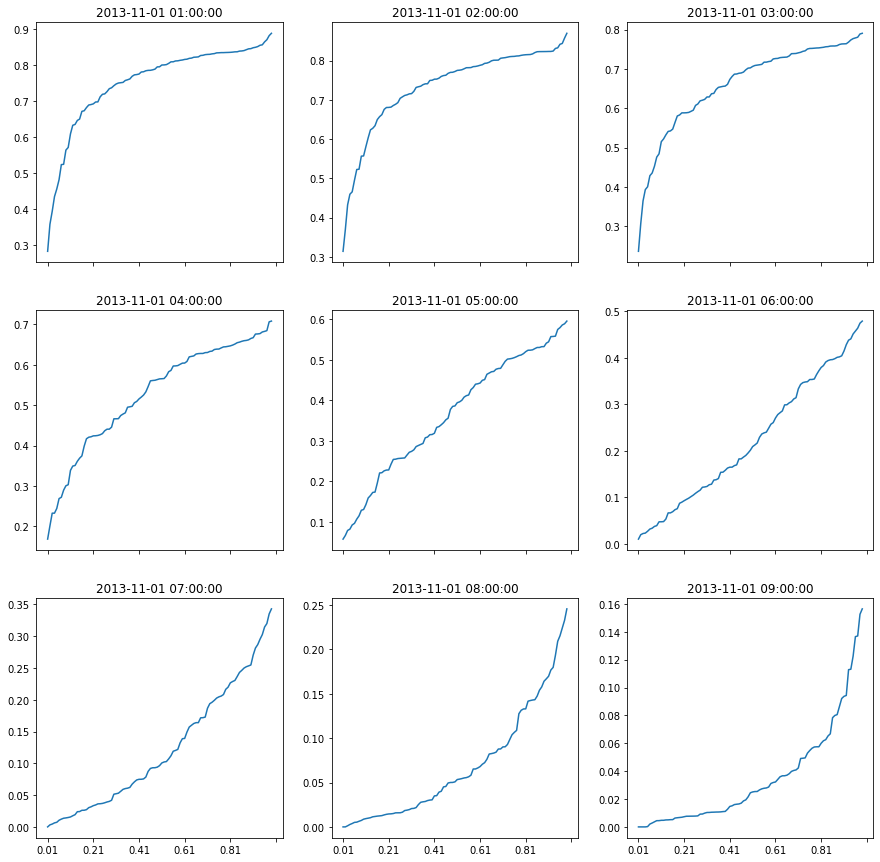

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, sharex=True, figsize=(15, 15))

for i in range(9):
    prediction.iloc[i].tail(99).plot(ax=ax[i // 3, i % 3],
                                     title=str(yq_output_df[-24*30:].index[i]))

# Evaluate Loss

The loss function is the pinnball loss:
$$ L(q_a, y) = \begin{cases}
    (1-\frac{a}{100})(q_a - y), &\text{if } y < q_a \\
    \frac{a}{100}(y-q_a), &\text{if } y \geq q_a.
\end{cases} $$

The score is then averaged over all target quantiles for all time periods over the forecast horizon and for all zones.

In [21]:
def pinnball_loss(actual, prediction):
    actual = actual[...,None]

    percentiles = np.empty((actual.shape[0], 99))
    for i in range(1, 100):
        percentiles[:, i-1] = i
    loss = np.where(actual < prediction,
                    (1 - percentiles / 100) * (prediction - actual),
                    percentiles / 100 * (actual - prediction))
    return loss

In [22]:
test_ts1 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)
test_ts2 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)
test_ts3 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)

prediction1 = prediction[prediction['ZONEID'] == 1].drop(columns='ZONEID')
prediction2 = prediction[prediction['ZONEID'] == 2].drop(columns='ZONEID')
prediction3 = prediction[prediction['ZONEID'] == 3].drop(columns='ZONEID')

loss1 = np.mean(pinnball_loss(test_ts1, prediction1))
loss2 = np.mean(pinnball_loss(test_ts2, prediction2))
loss3 = np.mean(pinnball_loss(test_ts3, prediction3))

loss = (loss1 + loss2 + loss3) / 3

print(f"Loss of task {task} with NNQF: {round(loss, 5)}")

Loss of task 9 with NNQF: 0.02726
